In [1]:
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list

/home/pferrazzi/miniconda3/envs/lm_finetune_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pferrazzi/miniconda3/envs/lm_finetune_env/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
import glob
import pandas as pd
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/test_data_processed/*.csv') #'data/mistral/test_data_processed/*.csv'
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    if file.strip().endswith('0.002.csv'):
        continue
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


In [15]:
## evaluation_results.to_csv('data/mistral/evaluation_results/results.csv', index=False)

In [23]:
evaluation_results[evaluation_results['similar_is_equal_threshold'] >= 100].sort_values(by='f1_score', ascending=False)['file'].to_list()[0:5]

['data/test_data_processed/maxNewTokensFactor8_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_8_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor8_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_8_0.0002.csv']

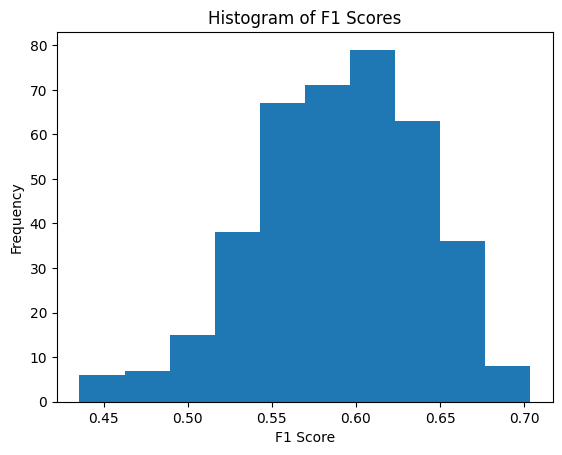

In [13]:
f1 = []
for _,eval in evaluators.items():
    f1.append(eval.evaluation_table['f1'])

import matplotlib.pyplot as plt

plt.hist(f1)
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.title('Histogram of F1 Scores')
plt.show()


### One Run

In [ ]:
file = 'data/mistral/8bit/maxNewTokensFactor8_nShotsInference4_Mistral-7B-Instruct-v0.2_adapters_en.layer1_8_torch.bfloat16_32_32_0.05_2_0.0002.csv'
eval_data = Dataset.from_csv(file) 
#display(eval_data.to_pandas().head(3))
output_cleaner = OutputCleaner()
similar_is_equal = False
similar_is_equal_threshold = 80
cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)#.select(range(138,139))

evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=similar_is_equal_threshold)


### BASE MODEL MISTRAL 8bit

In [ ]:
import glob
import pandas as pd
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/mistral/8bit_base/*.csv') 
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

for file in csv_files:
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


In [2]:
evaluation_results[evaluation_results['similar_is_equal_threshold'] >= 80].sort_values(by='f1_score', ascending=False)

,file,similar_is_equal,similar_is_equal_threshold,f1_score,precision,recall
133,data/mistral/8bit_base/maxNewTokensFactor8_nSh...,True,80,0.333916,0.260224,0.465835
132,data/mistral/8bit_base/maxNewTokensFactor8_nSh...,True,85,0.321196,0.250189,0.448482
131,data/mistral/8bit_base/maxNewTokensFactor8_nSh...,True,90,0.312688,0.243325,0.437364
130,data/mistral/8bit_base/maxNewTokensFactor8_nSh...,True,95,0.309780,0.241062,0.433297
138,data/mistral/8bit_base/maxNewTokensFactor8_nSh...,True,100,0.308811,0.240308,0.431941
...,...,...,...,...,...,...
19,data/mistral/8bit_base/maxNewTokensFactor2_nSh...,False,100,0.128506,0.281651,0.083243
31,data/mistral/8bit_base/maxNewTokensFactor2_nSh...,True,90,0.127428,0.085827,0.247289
30,data/mistral/8bit_base/maxNewTokensFactor2_nSh...,True,95,0.127009,0.085545,0.246475
38,data/mistral/8bit_base/maxNewTokensFactor2_nSh...,True,100,0.126729,0.085357,0.245933


### BASE MODEL MISTRAL 4bit

In [4]:
import glob
import pandas as pd
evaluators = {}
csv_files = glob.glob('data/mistral/4bit_base/*.csv') #'data/mistral/test_data_processed/*.csv'
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    if not file.strip().endswith('BaseModel.csv'):
        continue
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


Empty DataFrame
Columns: [file, similar_is_equal, similar_is_equal_threshold, f1_score, precision, recall]
Index: []
FILE:  data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1010.19it/s]
Generating train split: 681 examples [00:00, 18566.35 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 6039.70 examples/s]


FILE:  data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference4_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1166.70it/s]
Generating train split: 681 examples [00:00, 14656.59 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5538.93 examples/s]


FILE:  data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference2_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1058.10it/s]
Generating train split: 681 examples [00:00, 19236.04 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5934.20 examples/s]


FILE:  data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference3_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1174.88it/s]
Generating train split: 681 examples [00:00, 17891.59 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5895.42 examples/s]


FILE:  data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference1_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1421.80it/s]
Generating train split: 681 examples [00:00, 20514.24 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5946.56 examples/s]


In [7]:
evaluation_results['file'].to_list()

['data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference4_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference4_BaseModel.csv',
 'data/mistral/4bit_base/maxNewTokensFactor8_nShotsInference4_Ba

In [5]:
evaluation_results[evaluation_results['similar_is_equal_threshold'] >= 80].sort_values(by='f1_score', ascending=False)

,file,similar_is_equal,similar_is_equal_threshold,f1_score,precision,recall
13,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,80,0.466546,0.445486,0.489696
23,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,80,0.463026,0.446798,0.480477
33,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,80,0.461848,0.456885,0.466920
22,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,85,0.451200,0.434859,0.468818
12,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,85,0.446995,0.426217,0.469902
32,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,85,0.445845,0.440880,0.450922
21,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,90,0.442473,0.426345,0.459870
43,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,80,0.441708,0.445856,0.437636
20,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,95,0.440010,0.423869,0.457430
28,data/mistral/4bit_base/maxNewTokensFactor8_nSh...,True,100,0.438910,0.422758,0.456345


### MISTRAL 8bit

In [ ]:
import glob
import pandas as pd
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/mistral/8bit/*.csv') #'data/mistral/test_data_processed/*.csv'
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    # if file.strip().endswith('0.002.csv'):
    #     continue
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    #evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                #evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break

In [8]:
##evaluation_results.to_csv('data/evaluation_results/mistral_8bit.csv', index=False)

In [5]:
evaluation_results[evaluation_results['similar_is_equal_threshold']>=75].sort_values(by='f1_score', ascending=False)

,file,similar_is_equal,similar_is_equal_threshold,f1_score,precision,recall
535,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,75,0.648048,0.633049,0.663774
54,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,75,0.641816,0.602763,0.686280
555,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,75,0.638147,0.598386,0.683568
164,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,75,0.638144,0.631369,0.645065
534,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,80,0.631801,0.615860,0.648590
...,...,...,...,...,...,...
669,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,100,0.005189,0.019928,0.002983
663,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,85,0.005189,0.019928,0.002983
662,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,90,0.005189,0.019928,0.002983
661,data/mistral/8bit/maxNewTokensFactor8_nShotsIn...,True,95,0.005189,0.019928,0.002983


### LLAMA 8bit

In [ ]:
import glob
import pandas as pd
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/llama/8bit/*.csv') 
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


In [8]:
evaluator.data[1]

{'sentence': 'Hormonal study and dynamic biochemical tests performed indicated ECS.',
 'entities': "[{'id': '1704', 'offsets': array([ 9, 14]), 'role': '', 'semantic_type_id': '', 'text': 'study', 'type': 'EVENT'}\n {'id': '1719', 'offsets': array([39, 44]), 'role': '', 'semantic_type_id': '', 'text': 'tests', 'type': 'EVENT'}\n {'id': '1734', 'offsets': array([55, 64]), 'role': '', 'semantic_type_id': '', 'text': 'indicated', 'type': 'EVENT'}\n {'id': '1749', 'offsets': array([65, 68]), 'role': '', 'semantic_type_id': '', 'text': 'ECS', 'type': 'EVENT'}]",
 'original_text': 'A 46-year-old man with hypertension and dyslipidemia diagnosed 4-months before, as well as new-onset diabetes mellitus unveiled 1-month earlier, was referred to emergency department for hypokalemia. Hormonal study and dynamic biochemical tests performed indicated ECS. Imaging and cytological findings pointed toward a likely primary right parotid malignancy with liver metastases. Somatostatin receptor scintigraphy 

In [3]:
evaluation_results[evaluation_results['similar_is_equal_threshold']>=75].sort_values(by='f1_score', ascending=False)

,file,similar_is_equal,similar_is_equal_threshold,f1_score,precision,recall
354,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,75,0.405388,0.277098,0.754881
104,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,75,0.404637,0.276725,0.752440
353,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,80,0.398314,0.272060,0.743221
374,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,75,0.396249,0.271486,0.733189
103,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,80,0.396191,0.270660,0.738883
...,...,...,...,...,...,...
272,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,85,0.250214,0.182912,0.395879
271,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,90,0.248097,0.181227,0.393167
270,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,95,0.247070,0.180477,0.391540
278,data/llama/8bit/maxNewTokensFactor8_nShotsInfe...,True,100,0.246536,0.180080,0.390727


In [4]:
##evaluation_results.to_csv('data/evaluation_results/llama7b_8bit.csv', index=False)

### LLAM7 BASE 4bit

In [2]:
import glob
import pandas as pd
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/llama/7B_4bit_base/*.csv') 
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    #evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


Empty DataFrame
Columns: [file, similar_is_equal, similar_is_equal_threshold, f1_score, precision, recall]
Index: []
FILE:  data/llama/7B_4bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1506.57it/s]
Generating train split: 681 examples [00:00, 21887.01 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 7319.85 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor2_nShotsInference0_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1049.63it/s]
Generating train split: 681 examples [00:00, 22383.38 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 7445.70 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor8_nShotsInference4_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1089.15it/s]
Generating train split: 681 examples [00:00, 14026.19 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 3451.76 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor2_nShotsInference4_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1057.57it/s]
Generating train split: 681 examples [00:00, 13643.69 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 4963.91 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor4_nShotsInference1_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1103.18it/s]
Generating train split: 681 examples [00:00, 19175.22 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5977.12 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor4_nShotsInference2_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1070.52it/s]
Generating train split: 681 examples [00:00, 16804.95 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5625.94 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor8_nShotsInference2_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1119.68it/s]
Generating train split: 681 examples [00:00, 17501.00 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5628.09 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor4_nShotsInference4_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1076.01it/s]
Generating train split: 681 examples [00:00, 14247.77 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 4887.40 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor4_nShotsInference3_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1090.85it/s]
Generating train split: 681 examples [00:00, 16001.53 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 3716.73 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor4_nShotsInference0_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1027.26it/s]
Generating train split: 681 examples [00:00, 21557.30 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 7076.55 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor8_nShotsInference3_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1096.84it/s]
Generating train split: 681 examples [00:00, 15448.93 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5282.41 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor2_nShotsInference3_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1110.78it/s]
Generating train split: 681 examples [00:00, 15567.65 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5436.13 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor2_nShotsInference2_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1046.48it/s]
Generating train split: 681 examples [00:00, 15162.07 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 4847.34 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor2_nShotsInference1_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1086.04it/s]
Generating train split: 681 examples [00:00, 20809.41 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5906.13 examples/s]


FILE:  data/llama/7B_4bit_base/maxNewTokensFactor8_nShotsInference1_BaseModel.csv


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1079.34it/s]
Generating train split: 681 examples [00:00, 20528.84 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 5991.23 examples/s]


In [3]:
evaluation_results[evaluation_results['similar_is_equal_threshold']>=75].sort_values(by='f1_score', ascending=False)

,file,similar_is_equal,similar_is_equal_threshold,f1_score,precision,recall
144,data/llama/7B_4bit_base/maxNewTokensFactor8_nS...,True,75,0.271827,0.230436,0.331345
143,data/llama/7B_4bit_base/maxNewTokensFactor8_nS...,True,80,0.261285,0.221447,0.318601
142,data/llama/7B_4bit_base/maxNewTokensFactor8_nS...,True,85,0.254501,0.215631,0.310466
141,data/llama/7B_4bit_base/maxNewTokensFactor8_nS...,True,90,0.248140,0.210160,0.302874
140,data/llama/7B_4bit_base/maxNewTokensFactor8_nS...,True,95,0.247668,0.209744,0.302332
...,...,...,...,...,...,...
12,data/llama/7B_4bit_base/maxNewTokensFactor2_nS...,True,85,0.003781,0.466667,0.001898
13,data/llama/7B_4bit_base/maxNewTokensFactor2_nS...,True,80,0.003781,0.466667,0.001898
18,data/llama/7B_4bit_base/maxNewTokensFactor2_nS...,True,100,0.003781,0.466667,0.001898
10,data/llama/7B_4bit_base/maxNewTokensFactor2_nS...,True,95,0.003781,0.466667,0.001898


In [4]:
##evaluation_results.to_csv('data/evaluation_results/llama7b_4bit_base.csv', index=False)

### LLAMA7 BASE 8bit

In [5]:
import glob
import pandas as pd
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/llama/7B_8bit_base/*.csv') 
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    #evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


Empty DataFrame
Columns: [file, similar_is_equal, similar_is_equal_threshold, f1_score, precision, recall]
Index: []
FILE:  data/llama/7B_8bit_base/maxNewTokensFactor8_nShotsInference0_BaseModel.csv
FILE:  data/llama/7B_8bit_base/maxNewTokensFactor8_nShotsInference2_BaseModel.csv
FILE:  data/llama/7B_8bit_base/maxNewTokensFactor8_nShotsInference3_BaseModel.csv
FILE:  data/llama/7B_8bit_base/maxNewTokensFactor8_nShotsInference1_BaseModel.csv


In [6]:
evaluation_results[evaluation_results['similar_is_equal_threshold']>=75].sort_values(by='f1_score', ascending=False)

,file,similar_is_equal,similar_is_equal_threshold,f1_score,precision,recall
34,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,75,0.287719,0.244096,0.350325
4,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,75,0.285771,0.532939,0.195228
33,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,80,0.276906,0.234850,0.337310
3,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,80,0.271771,0.506282,0.185738
32,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,85,0.271473,0.230189,0.330803
31,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,90,0.265436,0.225052,0.323482
30,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,95,0.264457,0.224170,0.322397
38,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,100,0.263790,0.223605,0.321584
2,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,85,0.257732,0.479351,0.176247
1,data/llama/7B_8bit_base/maxNewTokensFactor8_nS...,True,90,0.252131,0.468681,0.172451


In [7]:
##evaluation_results.to_csv('data/evaluation_results/llama7b_8bit_base.csv', index=False)

### MISTRAL BASE simplest_prompt one run

In [4]:
from datasets import Dataset
from config import postprocessing
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list

file = 'data/test_data_processed/maxNewTokensFactor6_nShotsInference0_Mistral-7B-v0.1_simplest_prompt_adapters_en.layer1_4_torch.bfloat16_32_32_0.01_4_0.0002.csv'
eval_data = Dataset.from_csv(file) 
#display(eval_data.to_pandas().head(3))
output_cleaner = OutputCleaner()
similar_is_equal = True
similar_is_equal_threshold = 80
cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)#.select(range(138,139))

evaluator_mistral_base = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
evaluator_mistral_base.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=similar_is_equal_threshold)


file = 'data/mistral/4bit/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.01_4_0.0002.csv'
eval_data = Dataset.from_csv(file) 
#display(eval_data.to_pandas().head(3))
output_cleaner = OutputCleaner()
similar_is_equal = True
similar_is_equal_threshold = 80
cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)#.select(range(138,139))

evaluator_mistral_instruct = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
evaluator_mistral_instruct.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=similar_is_equal_threshold)

print(evaluator_mistral_instruct.evaluation_table)
print(evaluator_mistral_base.evaluation_table)



Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1050.15it/s]
Generating train split: 681 examples [00:00, 20161.65 examples/s]
Map: 100%|██████████| 681/681 [00:00<00:00, 6854.36 examples/s]


{'evaluation':      TP  FP  FN
0     0   0  10
1     0   1   4
2     0   0   4
3     5   0   0
4     1   0   1
..   ..  ..  ..
676   0   0   4
677   3   0   1
678   3   0   0
679   3   1   2
680   0   0   4

[681 rows x 3 columns], 'precision': 0.7130730050933786, 'recall': 0.34164859002169196, 'f1': 0.46196150320806595}
{'evaluation':      TP  FP  FN
0     2   0   8
1     3   0   1
2     2   1   2
3     3   0   2
4     2   1   0
..   ..  ..  ..
676   2   1   2
677   3   0   1
678   2   1   1
679   2   1   3
680   3   0   1

[681 rows x 3 columns], 'precision': 0.6405353728489483, 'recall': 0.2725054229934924, 'f1': 0.3823473463952825}
